1. 绘制 “多年平均火点热点图”

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import platform

In [2]:
plt.rcParams['axes.unicode_minus'] = False
system = platform.system()
if system == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC']
else:
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

In [22]:
fire_path = "cleaned_modis_hlj_gdf.shp"
if not os.path.exists(fire_path):
    raise FileNotFoundError(f"火点文件不存在：{fire_path}，请检查路径")
fire_gdf = gpd.read_file(fire_path)
fire_gdf = fire_gdf.to_crs(epsg=4326)
print(f"✅ 读取火点数据：共 {len(fire_gdf)} 个火点")

✅ 读取火点数据：共 200791 个火点


In [27]:
county_path = "counties_china.shp"
if not os.path.exists(county_path):
    raise FileNotFoundError(f"县界文件不存在：{county_path}，请检查路径")
county_gdf = gpd.read_file(county_path)
county_gdf = county_gdf.to_crs(epsg=4326)
print(f"✅ 读取全国县级边界：共 {len(county_gdf)} 个县")

✅ 读取全国县级边界：共 3121 个县


In [31]:
county_gdf = gpd.read_file(county_path).to_crs(epsg=4326)

In [37]:
import geopandas as gpd

county_path = "counties_china.shp"

In [38]:
county_gdf = gpd.read_file(county_path).to_crs(epsg=4326)

In [39]:
print("县界数据的所有字段名：")
print(county_gdf.columns.tolist())

县界数据的所有字段名：
['ADCODE99', 'LAST_NAME9', 'AVE_PROVIN', 'FIRST_NAME', 'geometry']


In [40]:
print("=== AVE_PROVIN 字段的值 ===")
print(county_gdf["AVE_PROVIN"].unique())

=== AVE_PROVIN 字段的值 ===
[11. 12. 13. 14. 15. 21. 22. 23. 31. 32. 33. 34. 35. 36. 37. 41. 42. 43.
 44. 45. 46. 50. 51. 52. 53. 54. 61. 62. 63. 64. 65. 66.]


In [41]:
print("\n=== FIRST_NAME 字段的值 ===")
print(county_gdf["FIRST_NAME"].unique())


=== FIRST_NAME 字段的值 ===
['Beijing_Core' 'Tongzhou' 'Shunyi' ... 'Qinghe2' 'Jimunai' 'Shihezi']


In [42]:
hlj_counties = county_gdf[county_gdf["AVE_PROVIN"] == 23].copy()

In [43]:
print(f"筛选到的黑龙江省县级行政区数量：{len(hlj_counties)}")

筛选到的黑龙江省县级行政区数量：79


In [44]:
print("黑龙江省部分县的英文名称：")
print(hlj_counties["FIRST_NAME"].head())

黑龙江省部分县的英文名称：
574    Haerbin_Core
575           Hulan
576           Yilan
577       Fangzheng
578         Binxian
Name: FIRST_NAME, dtype: object


In [45]:
fire_gdf = gpd.read_file(fire_path).to_crs(epsg=4326)
print(f"✅ 读取火点数据：{len(fire_gdf)} 个火点")

✅ 读取火点数据：200791 个火点


In [46]:
county_gdf = gpd.read_file(county_path).to_crs(epsg=4326)
hlj_counties = county_gdf[county_gdf["AVE_PROVIN"] == 23].copy()
if len(hlj_counties) == 0:
    raise ValueError("未筛选到黑龙江省，请检查代码是否正确（应为23）")
print(f"✅ 筛选黑龙江省：{len(hlj_counties)} 个县")

✅ 筛选黑龙江省：79 个县


In [47]:
fire_coords = np.vstack([fire_gdf.geometry.x, fire_gdf.geometry.y]).T
if len(fire_coords) < 10:
    raise ValueError("火点数量不足（至少10个）")

kde = stats.gaussian_kde(fire_coords.T)
x_min, y_min, x_max, y_max = hlj_counties.total_bounds
x_grid = np.arange(x_min, x_max, 0.1)
y_grid = np.arange(y_min, y_max, 0.1)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([X.ravel(), Y.ravel()])
density = kde(grid_points).reshape(X.shape)

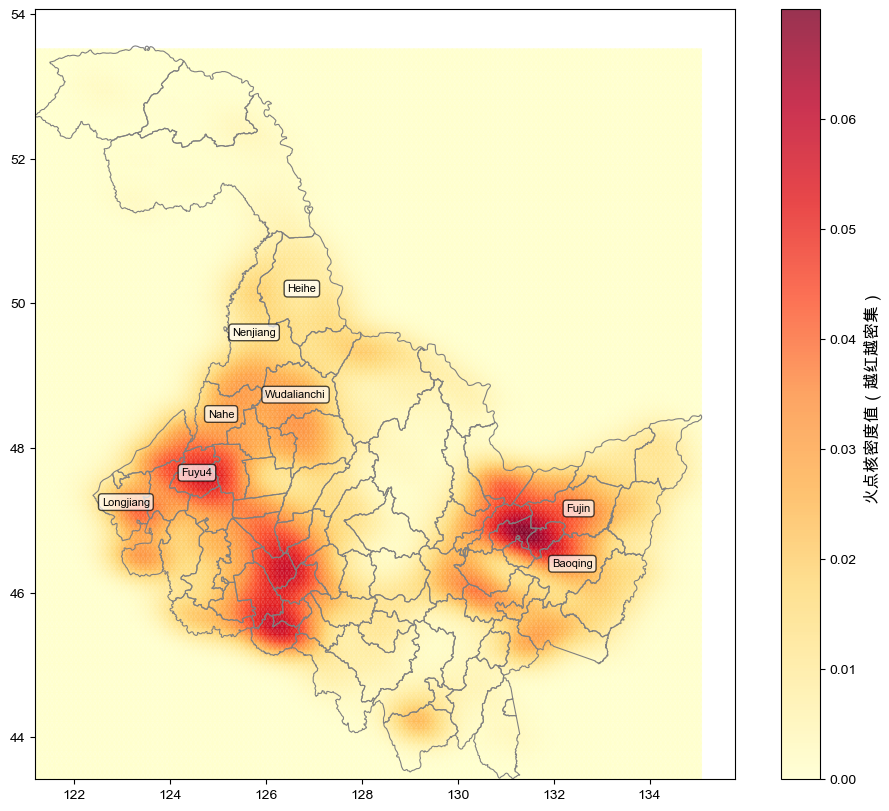

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(X, Y, density, cmap="YlOrRd", alpha=0.8, shading="gouraud")
hlj_counties.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.8)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("火点核密度值（越红越密集）", fontsize=12)

hlj_with_fire = hlj_counties.sjoin(fire_gdf, how="left", predicate="contains")
fire_counts = hlj_with_fire.groupby("ADCODE99")["index_right"].count()
fire_counts = fire_counts.reindex(hlj_counties["ADCODE99"], fill_value=0)
hlj_counties["fire_count"] = fire_counts.values
hotspot_threshold = hlj_counties["fire_count"].quantile(0.9)
hotspot_counties = hlj_counties[hlj_counties["fire_count"] >= hotspot_threshold]

for idx, row in hotspot_counties.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["FIRST_NAME"], fontsize=8,
            ha="center", va="center", bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.3"))

In [50]:
ax.set_title("2010-2019年黑龙江省火点多年平均热点图", fontsize=14, pad=20)
ax.set_xlabel("经度（°E）", fontsize=12)
ax.set_ylabel("纬度（°N）", fontsize=12)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid(linestyle="--", alpha=0.5)

output_path = "黑龙江省火点热点图.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

In [51]:
print(f"🎉 完成！热点图保存至：{os.path.abspath(output_path)}")

🎉 完成！热点图保存至：/Users/edith/miniprogram1/黑龙江省火点热点图.png


2. 绘制 “年均火点密度分布图”

In [64]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import platform

In [53]:
plt.rcParams['axes.unicode_minus'] = False
system = platform.system()
if system == 'Darwin':  # Mac
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC']
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

In [54]:
fire_path = "cleaned_modis_hlj_gdf.shp"
county_path = "counties_china.shp"

In [55]:
fire_gdf = gpd.read_file(fire_path).to_crs(epsg=4326)
if "year" not in fire_gdf.columns:
    raise ValueError("火点数据中未找到年份字段，请修改代码中的字段名（如‘acq_year’）")
print(f"✅ 读取火点数据：{len(fire_gdf)} 条，年份范围：{fire_gdf['year'].min()}~{fire_gdf['year'].max()}")

✅ 读取火点数据：200791 条，年份范围：2010~2019


In [56]:
county_gdf = gpd.read_file(county_path).to_crs(epsg=4326)
hlj_counties = county_gdf[county_gdf["AVE_PROVIN"] == 23].copy()
print(f"✅ 读取黑龙江县级边界：共 {len(hlj_counties)} 个县")

✅ 读取黑龙江县级边界：共 79 个县


In [57]:
hlj_counties_utm = hlj_counties.to_crs(epsg=32649)
hlj_counties["area_km2"] = hlj_counties_utm.geometry.area / 1e6
print(f"✅ 计算县域面积：平均面积 {hlj_counties['area_km2'].mean():.1f} 平方公里")

✅ 计算县域面积：平均面积 5962.4 平方公里


In [58]:
fire_with_county = gpd.sjoin(
    fire_gdf, 
    hlj_counties[["ADCODE99", "geometry"]],
    how="inner", 
    predicate="within"
)

In [59]:
print(f"✅ 匹配到县域的火点：{len(fire_with_county)} 个（部分火点可能在县外，已过滤）")

✅ 匹配到县域的火点：200554 个（部分火点可能在县外，已过滤）


In [61]:
year_county_fire = fire_with_county.groupby(["year", "ADCODE99"]).size().reset_index(name="fire_count")

In [62]:
county_yearly = year_county_fire.groupby("ADCODE99")["fire_count"].mean().reset_index(name="avg_yearly_fire")

In [65]:
all_counties = hlj_counties[["ADCODE99"]].copy()
county_avg_fire = pd.merge(all_counties, county_yearly, on="ADCODE99", how="left").fillna(0)

In [68]:
hlj_density = pd.merge(
    hlj_counties, 
    county_avg_fire, 
    on="ADCODE99", 
    how="left"
)
hlj_density["density"] = hlj_density["avg_yearly_fire"] / hlj_density["area_km2"]
hlj_density["density"] = hlj_density["density"].replace([np.inf, -np.inf], 0)
print(f"✅ 计算密度完成：平均密度 {hlj_density['density'].mean():.3f} 个/平方公里")

✅ 计算密度完成：平均密度 0.086 个/平方公里


In [69]:
pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 915.5 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


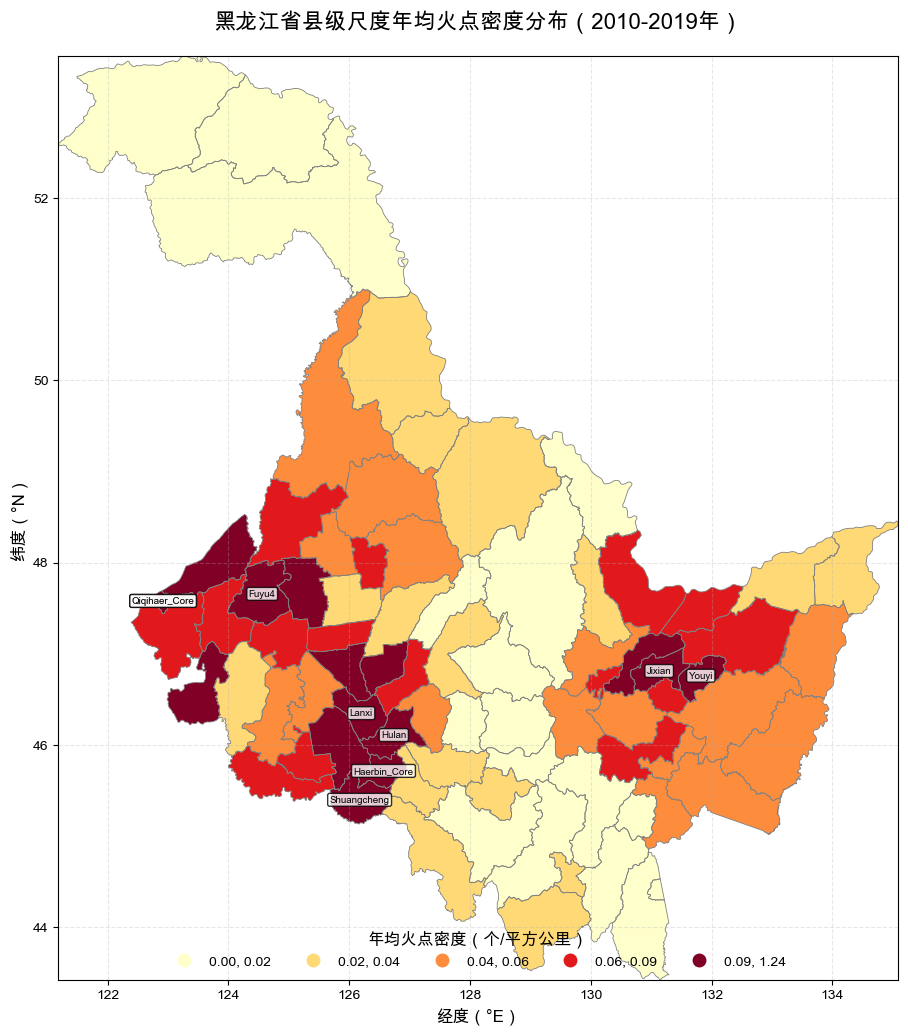

In [73]:
fig, ax = plt.subplots(figsize=(14, 12))

hlj_density.plot(
    column="density", 
    ax=ax,
    cmap="YlOrRd",
    legend=True, 
    legend_kwds={
        "title": "年均火点密度（个/平方公里）",
        "loc": "lower center",
        "ncol": 5,
        "fontsize": 10,
        "title_fontsize": 12,
        "frameon": False
    },
    missing_kwds={
        "color": "lightgray",
        "label": "无火点数据"
    },
    scheme="quantiles",
    k=5
)

hlj_counties.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.6
)

top10_threshold = hlj_density["density"].quantile(0.9)
top_counties = hlj_density[hlj_density["density"] >= top10_threshold]
for idx, row in top_counties.iterrows():
    if row["density"] > 0:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y,
            row["FIRST_NAME"],
            fontsize=7,
            ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.2")
        )

ax.set_title("黑龙江省县级尺度年均火点密度分布（2010-2019年）", fontsize=16, pad=20)
ax.set_xlabel("经度（°E）", fontsize=12)
ax.set_ylabel("纬度（°N）", fontsize=12)
ax.set_xlim(hlj_counties.total_bounds[[0, 2]])
ax.set_ylim(hlj_counties.total_bounds[[1, 3]])
ax.grid(linestyle="--", alpha=0.3)

In [74]:
output_path = "黑龙江省县级年均火点密度图.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"🎉 密度图已保存至：{os.path.abspath(output_path)}")

🎉 密度图已保存至：/Users/edith/miniprogram1/黑龙江省县级年均火点密度图.png
